In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob

In [2]:
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [35]:
img_path=glob.glob("d:/datasets/birds/*/*.jpg")*10

In [36]:
len(img_path)

1600

In [37]:
img_path[:5],img_path[-5:]

(['d:/datasets/birds\\005.Crested_Auklet\\0.jpg',
  'd:/datasets/birds\\005.Crested_Auklet\\1.jpg',
  'd:/datasets/birds\\005.Crested_Auklet\\10.jpg',
  'd:/datasets/birds\\005.Crested_Auklet\\11.jpg',
  'd:/datasets/birds\\005.Crested_Auklet\\12.jpg'],
 ['d:/datasets/birds\\008.Rhinoceros_Auklet\\5.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\6.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\7.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\8.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\9.jpg'])

In [38]:
import random
random.shuffle (img_path )

In [39]:
img_path[:5],img_path[-5:]

(['d:/datasets/birds\\006.Least_Auklet\\16.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\28.jpg',
  'd:/datasets/birds\\007.Parakeet_Auklet\\38.jpg',
  'd:/datasets/birds\\007.Parakeet_Auklet\\9.jpg',
  'd:/datasets/birds\\007.Parakeet_Auklet\\1.jpg'],
 ['d:/datasets/birds\\005.Crested_Auklet\\28.jpg',
  'd:/datasets/birds\\007.Parakeet_Auklet\\26.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\34.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\38.jpg',
  'd:/datasets/birds\\008.Rhinoceros_Auklet\\17.jpg'])

In [40]:
dic_l_name={0:"Crested_Auklet",1:"Least_Auklet",2:"Parakeet_Auklet",3:"Rhinoceros_Auklet"}

In [41]:
dic_n_l = dict(zip(dic_l_name.values(), dic_l_name.keys()))
dic_n_l

{'Crested_Auklet': 0,
 'Least_Auklet': 1,
 'Parakeet_Auklet': 2,
 'Rhinoceros_Auklet': 3}

In [42]:
all_image_labels=[dic_n_l.get(p.split(".")[1].split("\\")[0]) for p in img_path]

In [43]:
#all_image_labels = [ int(p.split("\\")[1][2])-5 for p in img_path]

In [44]:
all_image_labels[:5]

[1, 3, 2, 2, 2]

In [45]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.image.random_crop(image, [256, 256, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.5)
    image = tf.image.random_contrast(image, 0, 1)
    image = tf.cast(image, tf.float32)
    image = image/255.0  # normalize to [0,1] range
    return image

1155 airplane


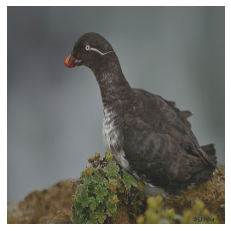

In [46]:
import matplotlib.pyplot as plt
rr=random.randint(0,len(img_path))
img_path_ = img_path[rr]
plt.imshow(load_and_preprocess_image(img_path_))
plt.axis("off")
print(rr,np.where(all_image_labels[rr]==1 ,"lake","airplane") )

In [47]:
path_ds = tf.data.Dataset.from_tensor_slices(img_path[:int(len(img_path)*.85)])
test_ds=tf.data.Dataset.from_tensor_slices(img_path[int(len(img_path)*.85):])

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [49]:
test_image_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [50]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels[:int(len(img_path)*.85)], tf.int64))
test_label_ds=all_image_labels[int(len(img_path)*.85):]

In [51]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [52]:
#image_label_ds.shuffle(len(img_path))

In [53]:
#val_count = int(len(img_path)*0.85*0.2)
train_count = (int(len(img_path)*0.85)) #- val_count

In [54]:
#val_count,train_count

In [55]:
#val_data = image_label_ds.take(val_count)
train_data = image_label_ds #.skip(val_count)

In [56]:
#train_data.take(5),test_ds,test_image_ds

In [57]:
BATCH_SIZE = 32

In [58]:
train_data = train_data.repeat()
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(AUTOTUNE)


In [59]:
#val_data = val_data.batch(BATCH_SIZE)
test_image_ds = test_image_ds.batch(BATCH_SIZE)

In [60]:
#train_data,val_data,test_image_ds

建立模型

In [67]:
model = tf.keras.Sequential()   #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization_1 (Batc  (None, 254, 254, 64)     256       
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,468
Trainable params: 6,340
Non-traina

In [69]:
model.compile(optimizer='adam',
              loss=tf.losses.sparse_categorical_crossentropy,
              metrics=['acc']
)

In [70]:
steps_per_epoch = train_count//BATCH_SIZE
#validation_steps = val_count//BATCH_SIZE

In [71]:
#steps_per_epoch,validation_steps

In [72]:
history = model.fit(train_data, epochs=200, steps_per_epoch=steps_per_epoch)

Epoch 1/200
42/42 [==============================] - 3s 49ms/step - loss: 1.2765 - acc: 0.3899
Epoch 2/200
42/42 [==============================] - 2s 49ms/step - loss: 1.2053 - acc: 0.4263
Epoch 3/200
42/42 [==============================] - 2s 49ms/step - loss: 1.1849 - acc: 0.4673
Epoch 4/200
42/42 [==============================] - 2s 49ms/step - loss: 1.1599 - acc: 0.4665
Epoch 5/200
42/42 [==============================] - 2s 49ms/step - loss: 1.1472 - acc: 0.4635
Epoch 6/200
42/42 [==============================] - 2s 49ms/step - loss: 1.1337 - acc: 0.4673
Epoch 7/200
42/42 [==============================] - 2s 49ms/step - loss: 1.1206 - acc: 0.4859
Epoch 8/200
42/42 [==============================] - 2s 49ms/step - loss: 1.1223 - acc: 0.4688
Epoch 9/200
42/42 [==============================] - 2s 49ms/step - loss: 1.1128 - acc: 0.4844
Epoch 10/200
42/42 [==============================] - 2s 49ms/step - loss: 1.1050 - acc: 0.4955
Epoch 11/200
42/42 [=============================

42/42 [==============================] - 2s 49ms/step - loss: 0.7969 - acc: 0.6793
Epoch 87/200
42/42 [==============================] - 2s 49ms/step - loss: 0.8019 - acc: 0.6466
Epoch 88/200
42/42 [==============================] - 2s 49ms/step - loss: 0.7828 - acc: 0.6734
Epoch 89/200
42/42 [==============================] - 2s 49ms/step - loss: 0.8117 - acc: 0.6533
Epoch 90/200
42/42 [==============================] - 2s 49ms/step - loss: 0.7744 - acc: 0.6882
Epoch 91/200
42/42 [==============================] - 2s 49ms/step - loss: 0.7890 - acc: 0.6607
Epoch 92/200
42/42 [==============================] - 2s 49ms/step - loss: 0.7698 - acc: 0.6801
Epoch 93/200
42/42 [==============================] - 2s 49ms/step - loss: 0.7903 - acc: 0.6548
Epoch 94/200
42/42 [==============================] - 2s 50ms/step - loss: 0.7730 - acc: 0.6704
Epoch 95/200
42/42 [==============================] - 2s 49ms/step - loss: 0.7801 - acc: 0.6689
Epoch 96/200
42/42 [==============================] -

42/42 [==============================] - 2s 49ms/step - loss: 0.6278 - acc: 0.7366
Epoch 171/200
42/42 [==============================] - 2s 49ms/step - loss: 0.6354 - acc: 0.7537
Epoch 172/200
42/42 [==============================] - 2s 49ms/step - loss: 0.6391 - acc: 0.7440
Epoch 173/200
42/42 [==============================] - 2s 49ms/step - loss: 0.6096 - acc: 0.7664
Epoch 174/200
42/42 [==============================] - 2s 49ms/step - loss: 0.6312 - acc: 0.7426
Epoch 175/200
42/42 [==============================] - 2s 49ms/step - loss: 0.6228 - acc: 0.7545
Epoch 176/200
42/42 [==============================] - 2s 49ms/step - loss: 0.6419 - acc: 0.7351
Epoch 177/200
42/42 [==============================] - 2s 49ms/step - loss: 0.6075 - acc: 0.7656
Epoch 178/200
42/42 [==============================] - 2s 49ms/step - loss: 0.6277 - acc: 0.7448
Epoch 179/200
42/42 [==============================] - 2s 49ms/step - loss: 0.6143 - acc: 0.7537
Epoch 180/200
42/42 [=======================

In [73]:
history.history.keys()

dict_keys(['loss', 'acc'])

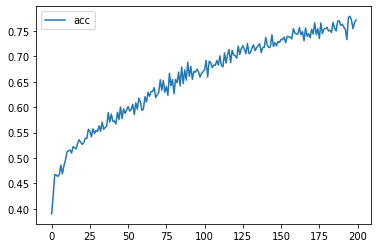

In [74]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
#plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

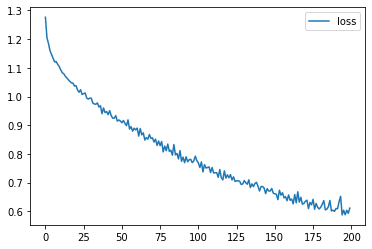

In [75]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
#plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

In [76]:
pred=model.predict(test_image_ds)

In [77]:
pred

array([[6.92152232e-03, 1.18802181e-02, 5.29976497e-12, 9.81198251e-01],
       [1.09001689e-01, 8.59081626e-01, 2.68640369e-02, 5.05272252e-03],
       [5.73712587e-01, 6.93870857e-02, 5.18842936e-02, 3.05016011e-01],
       [1.76762027e-04, 8.35768640e-01, 1.62657395e-01, 1.39727897e-03],
       [1.02737889e-01, 4.35268521e-01, 1.32083341e-01, 3.29910308e-01],
       [3.72696698e-01, 3.44572455e-01, 1.07594091e-03, 2.81654894e-01],
       [2.00519525e-02, 2.66794171e-02, 9.16312575e-01, 3.69560756e-02],
       [5.87958455e-01, 7.06719533e-02, 3.41302067e-01, 6.75830452e-05],
       [7.64155743e-07, 2.36244741e-05, 4.23789448e-09, 9.99975562e-01],
       [8.16376507e-01, 6.80410042e-02, 2.46247156e-09, 1.15582488e-01],
       [8.93306196e-01, 1.40209887e-02, 8.43804777e-02, 8.29236675e-03],
       [9.86573100e-01, 4.05901053e-04, 1.30210631e-02, 1.13680753e-13],
       [8.03587317e-01, 6.00967789e-03, 1.29633039e-01, 6.07699044e-02],
       [3.27148587e-02, 2.33441830e-01, 7.33781934e

In [78]:
pred_=np.argmax(pred,axis=1)

In [79]:
pred_

array([3, 1, 0, 1, 1, 0, 2, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 3, 0, 3,
       3, 0, 0, 0, 3, 3, 2, 0, 2, 1, 0, 0, 0, 2, 1, 3, 2, 2, 0, 3, 3, 1,
       3, 0, 3, 1, 0, 2, 0, 1, 3, 2, 1, 0, 0, 1, 0, 1, 0, 0, 2, 2, 2, 1,
       3, 3, 1, 0, 1, 0, 3, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 0, 0, 3, 1, 2,
       1, 0, 2, 0, 3, 2, 3, 0, 3, 3, 2, 2, 2, 3, 2, 0, 2, 0, 2, 1, 0, 3,
       1, 0, 3, 0, 0, 3, 0, 1, 2, 2, 3, 0, 2, 2, 1, 2, 0, 3, 3, 3, 1, 0,
       1, 1, 2, 0, 3, 0, 1, 3, 1, 2, 1, 0, 1, 2, 1, 3, 0, 0, 0, 0, 2, 3,
       0, 3, 0, 2, 1, 2, 3, 1, 2, 0, 0, 0, 2, 1, 1, 3, 2, 3, 1, 2, 3, 2,
       1, 0, 2, 3, 0, 0, 0, 1, 3, 3, 2, 3, 0, 3, 2, 0, 0, 0, 0, 3, 0, 3,
       1, 3, 1, 3, 3, 0, 0, 1, 0, 2, 1, 0, 1, 2, 0, 3, 1, 0, 2, 3, 0, 2,
       1, 3, 3, 0, 1, 0, 3, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 3, 3, 3],
      dtype=int64)

In [80]:
from  sklearn.metrics import classification_report

In [81]:
print(classification_report(test_label_ds,pred_))

              precision    recall  f1-score   support

           0       0.54      0.77      0.63        57
           1       0.79      0.70      0.74        60
           2       0.86      0.58      0.69        73
           3       0.77      0.86      0.81        50

    accuracy                           0.71       240
   macro avg       0.74      0.73      0.72       240
weighted avg       0.75      0.71      0.71       240

